In [1]:
# =========================
# EEG MI vs REST (CSV -> MNE -> Epochs -> CSP + LDA) on Google Colab + Google Drive
# =========================


In [2]:
# 1) Imports
!pip -q install mne

import numpy as np
import mne
from mne.datasets import eegbci
from mne.io import read_raw_edf

from mne.decoding import CSP
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GroupKFold, cross_val_score


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 42.1 MB/s eta 0:00:00


In [4]:
# 2) Settings
sfreq = 160  # EEGMMIDB is 160 Hz (you don't need to set this manually; raw carries it)
runs = [6, 10, 14]  # Task 4
subjects = [11]       # start with one subject; change later

# Use more motor channels (feet MI is midline-heavy)
#"FC1", "FCZ", "FC2","C1", "CZ", "C2", "C3", "C4","CP1", "CPZ", "CP2","PZ",
#"C3","Cz","C4"
eeg_chs = [
    "C3","Cz","C4","Fz","Pz"
]

epoch_len = None   # not used here; EEGMMIDB uses event-based epochs
overlap = 0.0      # not used here
l_freq, h_freq = 8.0, 30.0

# Epoch window relative to cue onset (common MI window)
tmin, tmax = 0.0,4.0

In [5]:
# -------------------------
# One RUN EDF -> epochs -> X, y, g (like file_to_epochs_XyG)
# -------------------------
def run_to_epochs_XyG(
    subject: int,
    run_number: int,
    group_id: int,
    eeg_chs: list[str],
    l_freq: float,
    h_freq: float,
    tmin: float,
    tmax: float
):
    # download EDF path for this subject+run
    edf_path = eegbci.load_data(subject, [run_number])[0]

    # read EDF
    raw = read_raw_edf(edf_path, preload=True, verbose=False)

    # standardize channel names/types for EEGBCI
    raw.rename_channels(lambda s: s.strip(".").upper())
    eegbci.standardize(raw)

    # keep EEG only
    raw.pick_types(eeg=True, exclude=[])

    # average reference (common)
    raw.set_eeg_reference("average", projection=False)

    # bandpass
    raw.filter(l_freq, h_freq, fir_design="firwin", verbose=False)

    # pick intersection of desired channels
    keep = [ch for ch in eeg_chs if ch in raw.ch_names]
    if len(keep) < 3:
        # too few channels present to do anything reasonable
        return None, None, None, keep

    raw.pick_channels(keep)

    # events from annotations (T0/T1/T2)
    events, event_id = mne.events_from_annotations(raw, verbose=False)

    # We only want T0 vs T2
    if "T0" not in event_id or "T2" not in event_id:
        return None, None, None, keep

    # --- Keep only T0 that immediately precedes a T2 (paired rest) ---
    t0 = event_id["T0"]
    t2 = event_id["T2"]

    paired_events = []

    # Keep all T2 events
    for e in events:
        if e[2] == t2:
            paired_events.append(e)

    # Keep only T0 events whose NEXT event is T2
    for i in range(len(events) - 1):
        if events[i, 2] == t0 and events[i + 1, 2] == t2:
            paired_events.append(events[i])

    paired_events = np.array(sorted(paired_events, key=lambda x: x[0]))

    epochs = mne.Epochs(
        raw,
        paired_events,
        event_id={"T0": t0, "T2": t2},
        tmin=tmin,
        tmax=tmax,
        baseline=None,
        preload=True,
        reject_by_annotation=True,
        verbose=False,
    )

    if len(epochs) == 0:
        return None, None, None, keep

    X = epochs.get_data()  # (n_epochs, n_channels, n_times)
    y = (epochs.events[:, 2] == event_id["T2"]).astype(int)  # T0->0, T2->1
    g = np.full(len(y), group_id, dtype=int)

    # must contain both classes
    if len(np.unique(y)) < 2:
        return None, None, None, keep

    print("T2 epochs:", (y == 1).sum())
    print("T0 epochs:", (y == 0).sum())

    return X, y, g, keep




In [6]:
X_list, y_list, g_list = [], [], []
kept_channels = None

for group_idx, run_number in enumerate(runs):
    Xr, yr, gr, keep = run_to_epochs_XyG(
        subject=subjects,
        run_number=run_number,
        group_id=group_idx,
        eeg_chs=eeg_chs,
        l_freq=l_freq,
        h_freq=h_freq,
        tmin=tmin,
        tmax=tmax
    )
    kept_channels = kept_channels or keep

    if Xr is None:
        print(f"Skipping subj {subject:03d} run {run_number}: no usable T0/T2 epochs.")
        continue

    X_list.append(Xr)
    y_list.append(yr)
    g_list.append(gr)

Using default location ~/mne_data for EEGBCI...
Creating /root/mne_data


Do you want to set the path:
    /root/mne_data
as the default EEGBCI dataset path in the mne-python config [y]/n? y
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Could not read the /root/.mne/mne-python.json json file during the writing. Assuming it is empty. Got: Expecting value: line 1 column 1 (char 0)
Download complete in 22s (2.4 MB)
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
T2 epochs: 7
T0 epochs: 7


Download complete in 07s (2.4 MB)
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
T2 epochs: 8
T0 epochs: 8


Download complete in 07s (2.4 MB)
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
T2 epochs: 8
T0 epochs: 8


In [9]:

X = np.concatenate(X_list, axis=0)
y = np.concatenate(y_list, axis=0)
groups = np.concatenate(g_list, axis=0)

print("Total epochs:", len(y))
print("Unique subjects:", len(np.unique(groups)))



Total epochs: 46
Unique subjects: 3


In [10]:
print("\n=== Dataset summary ===")
print("Subject:", subjects)
print("Channels kept:", kept_channels)
print("Total epochs:", X.shape[0])
print("X shape:", X.shape)
print("T2 (feet MI) epochs:", int((y == 1).sum()))
print("T0 (rest) epochs:", int((y == 0).sum()))
print("Num groups (runs used):", len(np.unique(groups)))


=== Dataset summary ===
Subject: [11]
Channels kept: ['C3', 'Cz', 'C4', 'Fz', 'Pz']
Total epochs: 46
X shape: (46, 5, 641)
T2 (feet MI) epochs: 23
T0 (rest) epochs: 23
Num groups (runs used): 3


In [11]:
# -------------------------
# CSP + LDA
# -------------------------
pipeline = Pipeline([
    ("csp", CSP(n_components=6, log=True, norm_trace=True)),
    ("lda", LinearDiscriminantAnalysis())
])


In [12]:
# -------------------------
# GroupKFold CV (prevents mixing adjacent trials across train/test)
# -------------------------
n_groups = len(np.unique(groups))
if n_groups < 2:
    raise ValueError(
        "Need at least 2 Experiment groups for GroupKFold.\n"
        "Record more experiment pairs or ensure filenames are consistent."
    )

cv = GroupKFold(n_splits=min(10, len(np.unique(groups))))

scores = cross_val_score(
    pipeline,
    X,
    y,
    cv=cv,
    groups=groups,
    scoring="accuracy",
    n_jobs=2
)

print("\n=== Results ===")
print("Fold accuracies:", scores)
print("Mean accuracy:", float(scores.mean()))



=== Results ===
Fold accuracies: [0.6875     0.75       0.64285714]
Mean accuracy: 0.6934523809523809


Computing rank from data with rank=None
    Using tolerance 7.5e-07 (2.2e-16 eps * 5 dim * 6.8e+08  max singular value)
    Estimated rank (data): 5
    data: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.2e-07 (2.2e-16 eps * 5 dim * 6.5e+08  max singular value)
    Estimated rank (data): 5
    data: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.9e-07 (2.2e-16 eps * 5 dim * 7.1e+08  max singular value)
    Estimated rank (data): 5
    data: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating class=0 covariance using EMPIRICAL
Done.
Estim

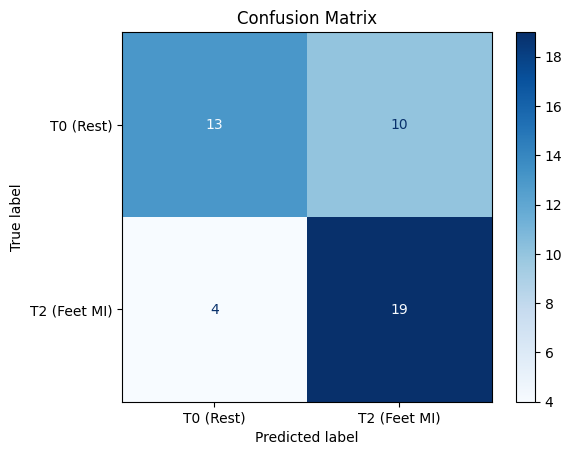

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true_all = []
y_pred_all = []

for train_idx, test_idx in cv.split(X, y, groups):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = pipeline.predict(X_test)

    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)

# Calculate the overall confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["T0 (Rest)", "T2 (Feet MI)"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()